In [1]:
#x01_populationStatistics

In [2]:
from chewc.callback import *
from chewc.policy import *
from chewc.sim import *
from chewc.lab import *
from chewc.config import *
from chewc.utils import *


import matplotlib.pyplot as plt
import uuid
import pdb
import torch
import torch
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter



from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList

In [3]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class CurriculumCallback(BaseCallback):
    def __init__(self, start_gen, end_gen, curriculum_steps, verbose=0):
        super(CurriculumCallback, self).__init__(verbose)
        self.start_gen = start_gen
        self.end_gen = end_gen
        self.curriculum_steps = curriculum_steps
        self.current_max_gen = start_gen

    def _on_step(self) -> bool:
        progress = min(1.0, self.n_calls / self.curriculum_steps)
        new_max_gen = int(self.start_gen + progress * (self.end_gen - self.start_gen))
        
        if new_max_gen > self.current_max_gen:
            self.current_max_gen = new_max_gen
            self.training_env.env_method("update_max_generations", new_max_gen)
            
            if self.verbose > 0:
                print(f"Updating max_generations to {new_max_gen}")
        
        return True

In [4]:
config = get_default_config()
config['n_parents'] = 5
config['n_loci'] = 1000
config['pop_size'] = 100
config['total_timesteps'] = 50000
config['start_gen'] = 2
config['end_gen'] = 10
config['seed'] = 4
config['sparse_reward'] = True
config['h2'] = 1

for i in config:
    print(f"{i} : {config[i]}")

observation_config : {'remaining_proportion': {'type': 'scalar', 'low': 0, 'high': 1}, 'genetic_variance': {'type': 'scalar', 'low': 0, 'high': inf}, 'mean_phenotype': {'type': 'scalar', 'low': -inf, 'high': inf}, 'max_breeding_value': {'type': 'scalar', 'low': -inf, 'high': inf}}
start_gen : 2
end_gen : 10
curriculum_steps : 100000
action_low : 0.01
action_high : 0.99
sparse_reward : True
n_parents : 5
n_chr : 1
n_loci : 1000
pop_size : 100
h2 : 1
target_mean : 0
target_variance : 1
reps : 1
total_timesteps : 50000
learning_rate : 0.0003
gae_lambda : 0.95
log_freq : 100
start_gae_lambda : 0.9
end_gae_lambda : 0.95
seed : 4


Best action: 0.120
Best average max phenotype in final generation: 15.241


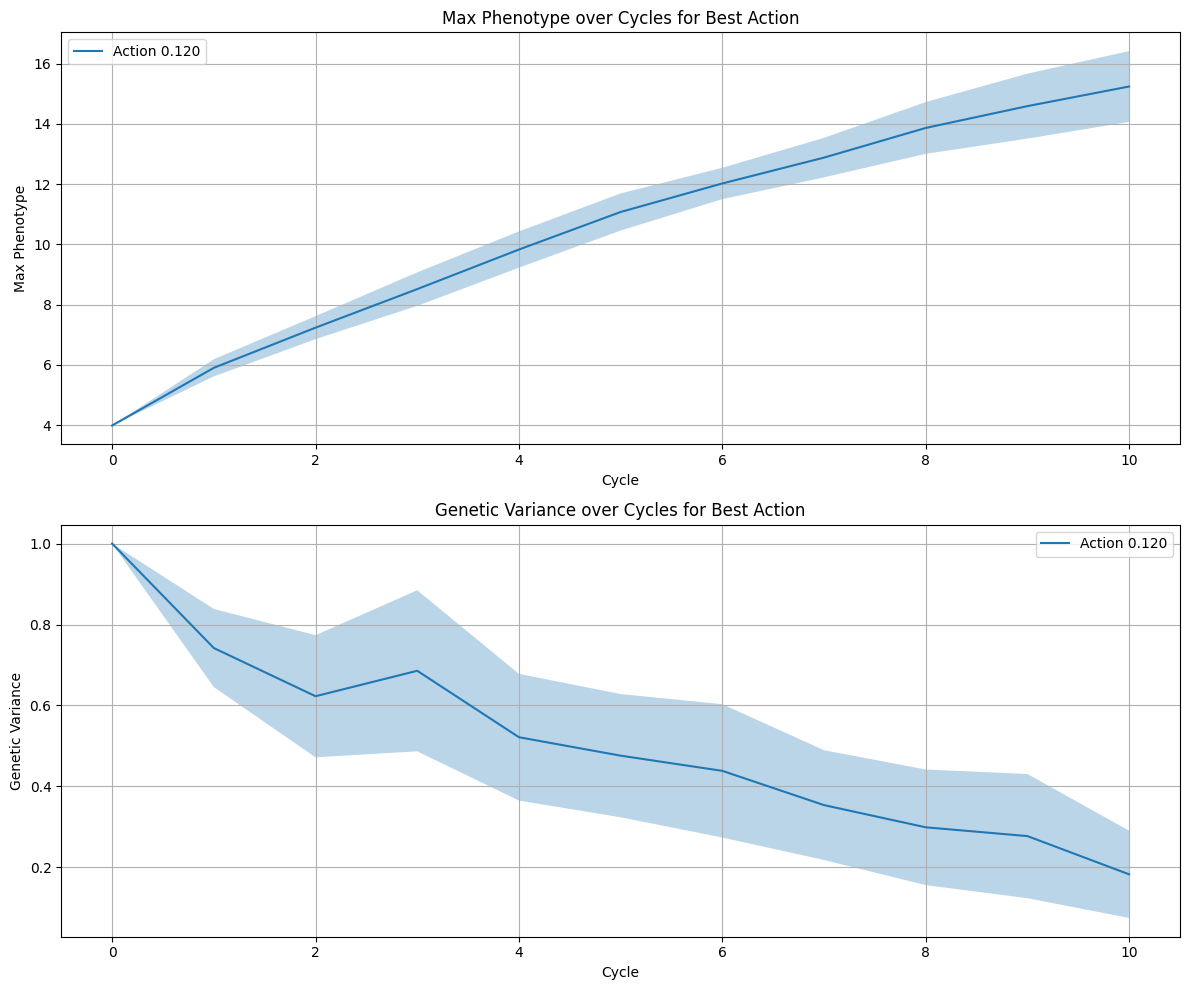

In [5]:

env = create_simulation(config)

    
# Usage remains the same
actions = np.linspace(.01, .35, 35)  # or however many actions you want to test
results, best_action, best_average = collect_baselines(env, actions, repetitions=10, cycles=config['end_gen'])

print(f"Best action: {best_action:.3f}")
print(f"Best average max phenotype in final generation: {best_average:.3f}")

# Plot the best run with both max phenotype and genetic variance
plot_best_run(results, best_action)

In [6]:
# FE = MultiScalarFeatureExtractor(env.observation_space)
# mock_observation = torch.tensor([[0.5,0.5,0.5,0.5,]], dtype=torch.float32)  # Single scalar input
# FE(mock_observation)

In [7]:
model = PPO(MultiScalarPolicy, env, verbose=1)
model.learn(total_timesteps=100)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 3        |
|    ep_rew_mean     | 8.07     |
| time/              |          |
|    fps             | 203      |
|    iterations      | 1        |
|    time_elapsed    | 10       |
|    total_timesteps | 2048     |
---------------------------------


In [8]:
class CurriculumCallback(BaseCallback):
    def __init__(self, start_gen, end_gen, total_steps, verbose=1):
        super(CurriculumCallback, self).__init__(verbose)
        self.start_gen = start_gen
        self.end_gen = end_gen
        self.total_steps = total_steps
        self.current_max_gen = start_gen
        print(f"CurriculumCallback initialized: start_gen={start_gen}, end_gen={end_gen}, total_steps={total_steps}")

    def _on_training_start(self):
        print("Training started. CurriculumCallback is active.")

    def _on_step(self) -> bool:
        # Calculate the progress as a fraction of total steps
        progress = min(1.0, self.n_calls / self.total_steps)
        
        # Linearly interpolate between start_gen and end_gen based on progress
        new_max_gen = int(self.start_gen + progress * (self.end_gen - self.start_gen))
        
        if new_max_gen > self.current_max_gen:
            self.current_max_gen = new_max_gen
            try:
                self.training_env.env_method("update_max_generations", new_max_gen)
                print(f"Step {self.n_calls}: Updated max_generations to {new_max_gen}")
            except Exception as e:
                print(f"Error updating max_generations: {e}")
        
        if self.n_calls % 1000 == 0:  # Print debug info every 1000 steps
            print(f"Step {self.n_calls}: Current progress = {progress:.2f}, Current max_gen = {self.current_max_gen}")
        
        return True

    def on_training_end(self):
        print(f"Training ended. Final max_generations: {self.current_max_gen}")
        
        
class ActionTrackingCallback(BaseCallback):
    def __init__(self, log_freq=100, verbose=0):
        super(ActionTrackingCallback, self).__init__(verbose)
        self.log_freq = log_freq
        self.episode_count = 0
        self.action_history = defaultdict(list)
        self.current_episode_actions = []
        self.step_count = 0
        self.writer = None

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _on_step(self) -> bool:
        self.step_count += 1
        info = self.locals['infos'][0]
        action = self.locals['actions'][0]
        current_generation = info['current_generation']
        max_generations = self.training_env.get_attr('max_generations')[0]

        normalized_action = info['normalized_action']

        self.current_episode_actions.append((current_generation, normalized_action))

        if self.locals['dones'][0]:
            self.episode_count += 1
            for gen, action in self.current_episode_actions:
                self.action_history[gen].append(action)
            self.current_episode_actions = []

            if self.episode_count % self.log_freq == 0:
                self._log_action_data(max_generations)

        return True

    def _log_action_data(self, max_generations):
        action_data = {}
        for gen in range(max_generations + 1):
            if gen in self.action_history:
                avg_action = np.mean(self.action_history[gen])
                action_data[f"generation_{gen}"] = avg_action

        self.writer.add_scalars("average_actions", action_data, self.step_count)
        self.action_history.clear()

    def on_training_end(self):
        max_generations = self.training_env.get_attr('max_generations')[0]
        self._log_action_data(max_generations)
        if self.writer:
            self.writer.close()
            
            
class AverageFinalGenerationCallback(BaseCallback):
    def __init__(self, log_freq=100, verbose=0):
        super(AverageFinalGenerationCallback, self).__init__(verbose)
        self.log_freq = log_freq
        self.phenotypes = []
        self.genetic_variances = []
        self.episode_count = 0
        self.all_action_values = []
        self.current_episode_actions = []

    def _on_step(self) -> bool:
        action = self.locals['actions'][0]
        self.current_episode_actions.append(action.item())
        
        for env_idx, done in enumerate(self.locals['dones']):
            if done:
                info = self.locals['infos'][env_idx]
                if 'final_generation' in info:
                    self.episode_count += 1
                    final_gen_info = info['final_generation']
                    
                    phenotype = final_gen_info['max_phenotype']
                    if isinstance(phenotype, torch.Tensor):
                        phenotype = phenotype.cpu().numpy()
                    self.phenotypes.append(phenotype)
                    
                    genetic_variance = final_gen_info['genetic_variance']
                    if isinstance(genetic_variance, torch.Tensor):
                        genetic_variance = genetic_variance.cpu().numpy()
                    self.genetic_variances.append(genetic_variance)
                    
                    self.all_action_values.extend(self.current_episode_actions)
                    self.current_episode_actions = []

                    if self.episode_count % self.log_freq == 0:
                        self._log_data()

        return True

    def _log_data(self):
        avg_phenotype = np.mean(self.phenotypes)
        avg_genetic_variance = np.mean(self.genetic_variances)
        self.logger.record("final_generation/max_phenotype", avg_phenotype)
        self.logger.record("final_generation/genetic_variance", avg_genetic_variance)
        
        self._plot_action_values()
        
        self.phenotypes = []
        self.genetic_variances = []
        self.all_action_values = []

    def _plot_action_values(self):
        plt.figure(figsize=(12, 6))
        plt.plot(self.all_action_values)
        plt.title(f"Action Values (Episodes {self.episode_count - self.log_freq + 1} to {self.episode_count})")
        plt.xlabel("Step within Episodes")
        plt.ylabel("Action Value")
        plt.ylim(0, 1)
        plt.savefig(f"action_values_plot_{self.episode_count}.png")
        plt.close()

    def on_training_end(self):
        self._plot_action_values()

In [11]:
from collections import defaultdict

model = PPO(
    MultiScalarPolicy,
    env,
    verbose=1,
    tensorboard_log='../dev_nbs/ppotb'
)


# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=10)
action_callback = ActionTrackingCallback(log_freq=10)
generation_callback = CurriculumCallback(config['start_gen'], config['end_gen'], total_steps= config['total_timesteps'])
# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback, generation_callback])
model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
CurriculumCallback initialized: start_gen=2, end_gen=10, total_steps=50000
Logging to ../dev_nbs/ppotb/PPO_24
Training started. CurriculumCallback is active.
Step 1000: Current progress = 0.02, Current max_gen = 2
Step 2000: Current progress = 0.04, Current max_gen = 2
----------------------------------
| final_generation/   |          |
|    genetic_variance | 0.307    |
|    max_phenotype    | 8.5      |
| rollout/            |          |
|    ep_len_mean      | 4        |
|    ep_rew_mean      | 8.32     |
| time/               |          |
|    fps              | 122      |
|    iterations       | 1        |
|    time_elapsed     | 16       |
|    total_timesteps  | 2048     |
----------------------------------
Step 3000: Current progress = 0.06, Current max_gen = 2
Step 4000: Current progress = 0.08, Current max_gen = 2
-----------------------------------------
| final_generation/       |

Step 17000: Current progress = 0.34, Current max_gen = 4
Step 18000: Current progress = 0.36, Current max_gen = 4
------------------------------------------
| final_generation/       |              |
|    genetic_variance     | 0.156        |
|    max_phenotype        | 10.8         |
| rollout/                |              |
|    ep_len_mean          | 5            |
|    ep_rew_mean          | 10.2         |
| time/                   |              |
|    fps                  | 119          |
|    iterations           | 9            |
|    time_elapsed         | 154          |
|    total_timesteps      | 18432        |
| train/                  |              |
|    approx_kl            | 0.0064681205 |
|    clip_fraction        | 0.0417       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.12        |
|    explained_variance   | 0.448        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.429        |
|    n_updates            

Step 31000: Current progress = 0.62, Current max_gen = 6
Step 31250: Updated max_generations to 7
Step 32000: Current progress = 0.64, Current max_gen = 7
------------------------------------------
| final_generation/       |              |
|    genetic_variance     | 0.0187       |
|    max_phenotype        | 11.1         |
| rollout/                |              |
|    ep_len_mean          | 8            |
|    ep_rew_mean          | 11.1         |
| time/                   |              |
|    fps                  | 120          |
|    iterations           | 16           |
|    time_elapsed         | 271          |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0035032541 |
|    clip_fraction        | 0.066        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.04        |
|    explained_variance   | 0.545        |
|    learning_rate        | 0.0003       |
|    loss                 | 

Step 46000: Current progress = 0.92, Current max_gen = 9
Step 47000: Current progress = 0.94, Current max_gen = 9
-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.00487     |
|    max_phenotype        | 11.5        |
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 12.2        |
| time/                   |             |
|    fps                  | 123         |
|    iterations           | 23          |
|    time_elapsed         | 380         |
|    total_timesteps      | 47104       |
| train/                  |             |
|    approx_kl            | 0.006046862 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.98       |
|    explained_variance   | 0.592       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.719       |
|    n_updates            | 220         |
|   